In [1]:
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve


from xgboost import XGBClassifier

import itertools
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import practice_code as pc
import individual_stats as ind

from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
clutch_time = pd.read_csv('CSV Files/clutch_time.csv')

In [3]:
clutch_time = pc.replace_nan(clutch_time)
clutch_time['total_blocks'] = (clutch_time['block'] != '')*1
clutch_time['assist_count'] = (clutch_time['assist'] != '')*1

In [4]:
reg = pd.read_csv('CSV Files/data_for_ids.csv')

In [5]:
ids = ind.add_ids(reg)

# Train_target (2015-2016 season)

In [6]:
train_target= clutch_time[clutch_time['data_set'] == '2015-2016 Regular Season']

In [7]:
stats_train_target = ind.object_to_int(train_target, 'points')
assists = ind.assist_stats(stats_train_target)
blks = ind.blk_stats(stats_train_target)
names = ind.player_names(stats_train_target)
train_target_stats = ind.merge_all(names, blks, assists, stats_train_target)
train_target_stats = ind.get_per_game_stats(train_target_stats)
train_target_stats = ind.merge_ids(train_target_stats, ids)

In [8]:
train_target_stats = ind.add_league_avg(train_target_stats)


In [9]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

# Train data (2004-2015)

In [10]:
train_clutch = clutch_time[clutch_time['data_set'] != '2015-2016 Regular Season']

In [11]:
train_clutch_time = pc.replace_nan(train_clutch)
train_clutch_time['total_blocks'] = (train_clutch_time['block'] != '')*1
train_clutch_time['assist_count'] = (train_clutch_time['assist'] != '')*1

In [12]:
player_stats_clutch = ind.object_to_int(train_clutch_time, 'points')
assists = ind.assist_stats(player_stats_clutch)
blks = ind.blk_stats(player_stats_clutch)
names = ind.player_names(player_stats_clutch)
train_clutch_stats = ind.merge_all(names, blks, assists, player_stats_clutch)
train_clutch_stats = ind.get_per_game_stats(train_clutch_stats)
train_clutch_stats = ind.merge_ids(train_clutch_stats, ids)

In [13]:
train_clutch_stats = ind.add_league_avg(train_clutch_stats)


# Test target (clutch or not in 2016-2017 season)

In [14]:
test_target = pd.read_csv('Test_data/first_test.csv')

In [15]:
test_target = test_target.drop('id', axis =1)
test_target = ind.merge_ids(test_target, ids)
test_target = ind.add_league_avg(test_target)

# X_test data

In [16]:
test_clutch_time = pc.replace_nan(clutch_time)
test_clutch_time['total_blocks'] = (test_clutch_time['block'] != '')*1
test_clutch_time['assist_count'] = (test_clutch_time['assist'] != '')*1

In [17]:
player_stats_test = ind.object_to_int(test_clutch_time, 'points')
assists = ind.assist_stats(player_stats_test)
blks = ind.blk_stats(player_stats_test)
names = ind.player_names(player_stats_test)
test_clutch_stats = ind.merge_all(names, blks, assists, player_stats_test)
test_clutch_stats = ind.get_per_game_stats(test_clutch_stats)
test_clutch_stats = ind.merge_ids(test_clutch_stats, ids)

In [18]:
test_clutch_stats = ind.add_league_avg(test_clutch_stats)

# import csv files for turnovers and ejections

### Keep al the ejections from total game sbecause if they are ejected they cant comebacck

In [19]:
turnover_data = turnover_data[turnover_data['data_set']!= '2015-2016 Regular Season']

In [20]:
turnover_data['pts_difference'] = turnover_data['away_score'] - turnover_data['home_score']

In [21]:
turnover_data = pc.clutch_moment(turnover_data)

In [22]:
x = turnover_data.groupby('player').count()
turnover_data = x[['event_type']]
turnover_data.reset_index(level=0, inplace=True)
turnover_data = turnover_data.rename(columns={'event_type':'total_turnovers'})

# merge these to train data

In [23]:
train_clutch_stats = pd.merge(train_clutch_stats,turnover_data,on='player', how = 'left')


In [24]:
train_clutch_stats = train_clutch_stats.fillna(0)

In [25]:
train_clutch_stats['TPG'] = round(train_clutch_stats['total_turnovers'] / train_clutch_stats['total_games'],2)

# get TO data for train target

In [26]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [27]:
target_turnover_data = turnover_data[turnover_data['data_set'] == '2015-2016 Regular Season']

In [28]:
target_turnover_data['pts_difference'] = target_turnover_data['away_score'] - target_turnover_data['home_score']

In [29]:
target_turnover_data = pc.clutch_moment(target_turnover_data)

In [30]:
x = target_turnover_data.groupby('player').count()
target_turnover_data = x[['event_type']]
target_turnover_data.reset_index(level=0, inplace=True)
target_turnover = target_turnover_data.rename(columns={'event_type':'total_turnovers'})

In [31]:
train_target_stats = pd.merge(train_target_stats,target_turnover,on='player', how = 'left')
train_target_stats = train_target_stats.fillna(0)
train_target_stats['TPG'] = round(train_target_stats['total_turnovers'] / train_target_stats['total_games'],2)

# Do the same for x_test aka clutch time

In [32]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [33]:
turnover_data['pts_difference'] = turnover_data['away_score'] - turnover_data['home_score']
turnover_data = pc.clutch_moment(turnover_data)

In [34]:
x = turnover_data.groupby('player').count()
turnover_data = x[['event_type']]
turnover_data.reset_index(level=0, inplace=True)
turnover_data = turnover_data.rename(columns={'event_type':'total_turnovers'})

In [35]:
test_clutch_stats = pd.merge(test_clutch_stats,turnover_data,on='player', how = 'left')
test_clutch_stats = test_clutch_stats.fillna(0)
test_clutch_stats['TPG'] = round(test_clutch_stats['total_turnovers'] / test_clutch_stats['total_games'],2)

# And for the test target

In [36]:
test_target = pd.read_csv('Every_Season_Data/[2016-2017]-combined-stats.csv')
turnovers = test_target[test_target['event_type'].str.contains('urnover')]
turnovers['pts_difference'] = turnovers['away_score'] - turnovers['home_score']
turnovers = pc.clutch_moment(turnovers)
x = turnovers.groupby('player').count()
turnovers = x[['event_type']]
turnovers.reset_index(level=0, inplace=True)
turnovers = turnovers.rename(columns={'event_type':'total_turnovers'})

In [37]:
test_target = pd.read_csv('Every_Season_Data/[2016-2017]-combined-stats.csv')

In [38]:
test_target =  pc.add_columns(test_target)

In [39]:
col_to_remove = ['a1', 'a2', 'a3','a4','a5','h1','h2','h3','h4','h5', 'play_length', 'entered', 'left', 'possession', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y', 'num', 'away', 'home', 'outof', 'opponent', 'reason', 'elapsed', 'play_id']

In [40]:
test_target = pc.replace_nan(test_target)
test_target = pc.remove_col(test_target, col_to_remove)
test_target = pc.remove_junk_rows(test_target, 'event_type')
regu, poffs = pc.regular_or_playoffs(test_target, 'data_set')

In [41]:
clutch = pc.clutch_moment(regu)
clutch = pc.remove_not_imp_games(clutch, 'game_id')

In [42]:
clutch = ind.object_to_int(clutch, 'points')
ast = ind.assist_stats(clutch)
blk = ind.blk_stats(clutch)
nme = ind.player_names(clutch)
clutch = ind.merge_all(nme, blk, ast, clutch)

In [43]:
test_target = ind.get_per_game_stats(clutch)
test_target = ind.merge_ids(test_target, ids)

In [44]:
test_target = ind.add_league_avg(test_target)


In [45]:
target = pd.merge(test_target,turnovers,on='player', how = 'left')
target = target.fillna(0)
target['TPG'] = round(target['total_turnovers'] / target['total_games'],2)

# Add clutch scores

In [46]:
train_target_stats = ind.add_scores(train_target_stats)
target = ind.add_scores(target)
train_clutch_stats = ind.add_scores(train_clutch_stats)
test_clutch_stats = ind.add_scores(test_clutch_stats)

In [47]:
train_target_stats = ind.is_clutch(train_target_stats)
target = ind.is_clutch(target)
train_clutch_stats = ind.is_clutch(train_clutch_stats)
test_clutch_stats = ind.is_clutch(test_clutch_stats)

# making sure that i have same players in y_train and x_train

In [48]:
players = train_target_stats[['player']]
X_train_clutch_stats = train_clutch_stats.merge(players, on='player')


In [49]:
x = train_clutch_stats[['player']]
Y_train_target_stats = train_target_stats.merge(x, on='player')

# gotta get the same players in x_test and y_test

In [50]:
d = target[['player']]
X_valid_clutch_stats = test_clutch_stats.merge(d, on='player')

In [51]:
y = test_clutch_stats[['player']]
Y_valid = target.merge(y, on='player')

# GradientBoost

In [52]:
y_trainGB = Y_train_target_stats['is_clutch']
x_trainGB = X_train_clutch_stats.drop(['APG','FT_missed','3pt%', 'ORPG','total_games','easy_shot%','total_shots', 
'2fg_attempts', 'Dunk/Layup_attempts', '3pt_shots','assist_count','clutch_score', 'is_clutch', 'total_blocks', 
'2pt_fg_made','Dunk/Layup', 'shots_made', 'BPG','FT%','league_all_shot_avg', 'league_2pt_avg', 'league_3pt_avg',
   'league_hard2pt_avg', 'league_easy2pt_avg', 'league_ft%','player', 'player_id'], axis = 1)

In [53]:
y_testGB = Y_valid['is_clutch']
x_testGB = X_valid_clutch_stats.drop(['APG','FT_missed','3pt%', 'ORPG','total_games','easy_shot%','total_shots', 
'2fg_attempts', 'Dunk/Layup_attempts', '3pt_shots','assist_count','clutch_score', 'is_clutch', 'total_blocks', 
'2pt_fg_made','Dunk/Layup', 'shots_made', 'BPG','FT%','league_all_shot_avg', 'league_2pt_avg', 'league_3pt_avg',
   'league_hard2pt_avg', 'league_easy2pt_avg', 'league_ft%','player', 'player_id'], axis = 1)

In [54]:
modelGB= GradientBoostingClassifier(learning_rate=0.23, max_depth=4, min_samples_leaf=9, n_estimators=1000)
modelGB.fit(x_trainGB, y_trainGB)
predGB= modelGB.predict(x_testGB)


In [55]:
accuracy_score(y_testGB, predGB)

0.7653846153846153

In [56]:
precision_score(y_testGB, predGB)

0.2857142857142857

In [57]:
recall_score(y_testGB, predGB)

0.21739130434782608

In [58]:
f1_score(y_testGB, predGB)

0.24691358024691357

In [59]:
importances = modelGB.feature_importances_
importances

array([0.01116698, 0.01233435, 0.00520595, 0.00783349, 0.0096022 ,
       0.02485875, 0.00965879, 0.01066209, 0.01583878, 0.01240486,
       0.00273276, 0.00892078, 0.01418068, 0.00837306, 0.0068792 ,
       0.01159355, 0.01601996, 0.01073375])

# Grid Search for graident boost

In [60]:
parameters = {'learning_rate': [.23], 'n_estimators': [ 1000, 1040], 'max_depth': [4], 
              'min_samples_leaf':[9]}

In [62]:
gbc = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, scoring='f1')
gbc.fit(x_trainGB, y_trainGB)

In [79]:
gbc.best_params_

{'learning_rate': 0.23,
 'max_depth': 4,
 'min_samples_leaf': 9,
 'n_estimators': 1040}

In [80]:
gbc.best_score_

0.25339251589251593

# Grid Search XGB

In [246]:
params={'max_depth': [3],'learning_rate': [.24,.25,.26], 
        'n_estimators': [170,160], 'min_child_weight':[2]}

In [247]:
XGB = GridSearchCV(XGBClassifier(), params, cv= 10, scoring='f1')
XGB.fit(x_trainX, y_trainX)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3], 'learning_rate': [0.24, 0.25, 0.26], 'n_estimators': [170, 160], 'min_child_weight': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [248]:
XGB.best_params_

{'learning_rate': 0.25,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 160}

In [249]:
XGB.best_score_

0.2918416793416793

# XGBoost

In [63]:
x_trainX = X_train_clutch_stats.drop(['FT_missed','3pt%', 'ORPG','total_games',
    'easy_shot%','total_shots', '2fg_attempts', 'Dunk/Layup_attempts', '3pt_shots',
    'assist_count', 'APG', 'clutch_score', 'is_clutch', 'total_blocks', '2pt_fg_made', 
'Dunk/Layup', 'shots_made', 'BPG',
    'FT%','league_all_shot_avg', 'league_2pt_avg', 'league_3pt_avg',
       'league_hard2pt_avg', 'league_easy2pt_avg', 'league_ft%','player', 'player_id'], axis = 1)
y_trainX = Y_train_target_stats['is_clutch']


In [64]:
x_testX = X_valid_clutch_stats.drop(['FT_missed', 'APG',
    '3pt%', 'ORPG','total_games',
    'easy_shot%','total_shots', '2fg_attempts', 'Dunk/Layup_attempts', '3pt_shots',
    'assist_count',
    'clutch_score', 'is_clutch', 'total_blocks', '2pt_fg_made', 
'Dunk/Layup', 'shots_made', 'BPG',
    'FT%','league_all_shot_avg', 'league_2pt_avg', 'league_3pt_avg',
       'league_hard2pt_avg', 'league_easy2pt_avg', 'league_ft%','player', 'player_id'],axis =1)
y_testX = Y_valid['is_clutch']

In [65]:
modelX = XGBClassifier(learning_rate=.2, max_depth=3, n_estimators=150, min_child_weight=1)
modelX.fit(x_trainX, y_trainX)
y_predX=modelX.predict(x_testX)
print("recall: %.5f%%" % recall_score(y_testX, y_predX))
print("f1: %.5f%%" % f1_score(y_testX, y_predX))
print("Accuracy: %.5f%%" % accuracy_score(y_testX, y_predX))
print("precision: %.5f%%" % precision_score(y_testX, y_predX))

recall: 0.21739%
f1: 0.25641%
Accuracy: 0.77692%
precision: 0.31250%


In [66]:
x = modelX.feature_importances_
x

array([0.04672897, 0.0293725 , 0.02269693, 0.05073431, 0.04405874,
       0.11615487, 0.03337784, 0.06542056, 0.11081442, 0.05874499,
       0.02803738, 0.0493992 , 0.09212283, 0.04672897, 0.00400534,
       0.06675567, 0.07743658, 0.05740988], dtype=float32)

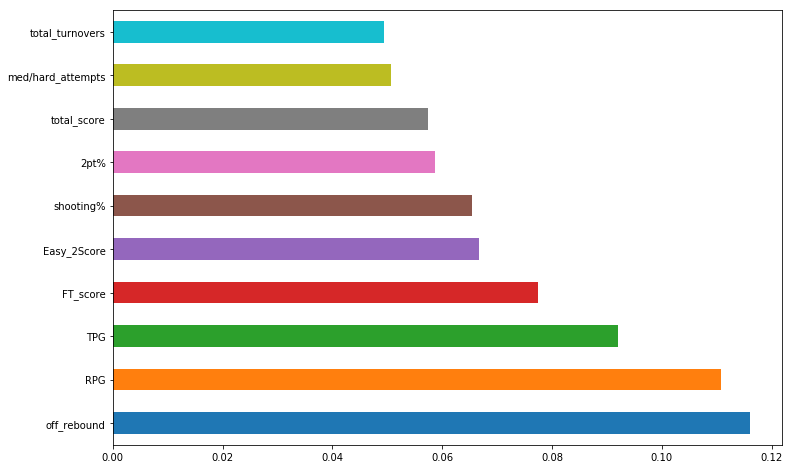

In [67]:
ig, axs = plt.subplots(1,0, figsize=(12,8))
(pd.Series(x, index=x_testX.columns)
   .nlargest(10)
   .plot(kind='barh'));

# Baseline model 
## Looks at all the shots and if your shooting% is above league avg yu are clutch 

In [68]:
x_train = X_train_clutch_stats.drop(['player', 'player_id'],axis = 1)
y_train = Y_train_target_stats['is_clutch']
y_test = Y_valid['is_clutch']
x_test = X_valid_clutch_stats.drop(['player', 'player_id'],axis = 1)

In [69]:
model= GradientBoostingClassifier()
fit = model.fit(x_train, y_train)
pred= fit.predict(x_test)

In [70]:
recall_score(y_test, pred)

0.15217391304347827

In [71]:
f1_score(y_test, pred)

0.19444444444444445

In [72]:
accuracy_score(y_test, pred)

0.7769230769230769

In [73]:
precision_score(y_test, pred)

0.2692307692307692

# Final test data

In [74]:
final_test = pd.read_csv('Every_Season_Data/[2017-2018]-combined-stats.csv', error_bad_lines=False)

b'Skipping line 34257: expected 44 fields, saw 46\nSkipping line 34258: expected 44 fields, saw 46\nSkipping line 34259: expected 44 fields, saw 46\nSkipping line 34260: expected 44 fields, saw 46\nSkipping line 34261: expected 44 fields, saw 46\nSkipping line 34262: expected 44 fields, saw 46\nSkipping line 34263: expected 44 fields, saw 46\nSkipping line 34264: expected 44 fields, saw 46\nSkipping line 34265: expected 44 fields, saw 46\nSkipping line 34266: expected 44 fields, saw 46\nSkipping line 34267: expected 44 fields, saw 46\nSkipping line 34268: expected 44 fields, saw 46\nSkipping line 34269: expected 44 fields, saw 46\nSkipping line 34270: expected 44 fields, saw 46\nSkipping line 34271: expected 44 fields, saw 46\nSkipping line 34272: expected 44 fields, saw 46\nSkipping line 34273: expected 44 fields, saw 46\nSkipping line 34274: expected 44 fields, saw 46\nSkipping line 34275: expected 44 fields, saw 46\nSkipping line 34276: expected 44 fields, saw 46\nSkipping line 3427

In [75]:
final_test = pc.add_columns(final_test)
final_test = pc.remove_junk_rows(final_test, 'event_type')
col_to_remove = ['a1', 'a2', 'a3','a4','a5','h1','h2','h3','h4','h5', 'play_length', 'entered', 'left', 'possession', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y', 'num', 'away', 'home', 'outof', 'opponent', 'reason', 'elapsed', 'play_id']
final_test = pc.remove_col(final_test, col_to_remove)
final_test = pc.replace_nan(final_test)
final_regular_season, final_playoffs = pc.regular_or_playoffs(final_test, 'data_set')
final_clutch = pc.clutch_moment(final_regular_season)
final_clutch = pc.remove_not_imp_games(final_clutch, 'game_id')

In [76]:
final_clutch['total_blocks'] = (final_clutch['block'] != '')*1
final_clutch['assist_count'] = (final_clutch['assist'] != '')*1

In [77]:
test_stats_clutch = ind.change_objects(final_clutch)

In [78]:
assists = ind.assist_stats(test_stats_clutch)
blks = ind.blk_stats(test_stats_clutch)
names = ind.player_names(test_stats_clutch)
names = ind.player_names(test_stats_clutch)
full_test_clutch_stats = ind.merge_all(names, blks, assists, test_stats_clutch)
full_test_clutch_stats = ind.get_per_game_stats(full_test_clutch_stats)
full_test_clutch_stats = ind.merge_ids(full_test_clutch_stats, ids)

In [79]:
full_test_clutch_stats = ind.add_league_avg(full_test_clutch_stats)

In [80]:
final_tos = pd.read_csv('Every_Season_Data/[2017-2018]-combined-stats.csv', error_bad_lines=False)
final_turnovers = final_tos[final_tos['event_type'].str.contains('urnover')]
final_turnovers['pts_difference'] = final_turnovers['away_score'] - final_turnovers['home_score']
final_turnovers = pc.clutch_moment(final_turnovers)
x = final_turnovers.groupby('player').count()
final_turnovers = x[['event_type']]
final_turnovers.reset_index(level=0, inplace=True)
final_turnovers = final_turnovers.rename(columns={'event_type':'total_turnovers'})

b'Skipping line 34257: expected 44 fields, saw 46\nSkipping line 34258: expected 44 fields, saw 46\nSkipping line 34259: expected 44 fields, saw 46\nSkipping line 34260: expected 44 fields, saw 46\nSkipping line 34261: expected 44 fields, saw 46\nSkipping line 34262: expected 44 fields, saw 46\nSkipping line 34263: expected 44 fields, saw 46\nSkipping line 34264: expected 44 fields, saw 46\nSkipping line 34265: expected 44 fields, saw 46\nSkipping line 34266: expected 44 fields, saw 46\nSkipping line 34267: expected 44 fields, saw 46\nSkipping line 34268: expected 44 fields, saw 46\nSkipping line 34269: expected 44 fields, saw 46\nSkipping line 34270: expected 44 fields, saw 46\nSkipping line 34271: expected 44 fields, saw 46\nSkipping line 34272: expected 44 fields, saw 46\nSkipping line 34273: expected 44 fields, saw 46\nSkipping line 34274: expected 44 fields, saw 46\nSkipping line 34275: expected 44 fields, saw 46\nSkipping line 34276: expected 44 fields, saw 46\nSkipping line 3427

In [81]:
full_test_clutch_stats = pd.merge(full_test_clutch_stats, final_turnovers, on='player', how = 'left')
full_test_clutch_stats = full_test_clutch_stats.fillna(0)
full_test_clutch_stats['TPG'] = round(full_test_clutch_stats['total_turnovers'] / full_test_clutch_stats['total_games'],2)

In [82]:
full_test_clutch_stats = ind.add_scores(full_test_clutch_stats)

full_test_clutch_stats = ind.is_clutch(full_test_clutch_stats)

# Final X_train

In [83]:
final_train = ind.object_to_int(clutch_time, 'points')
assists = ind.assist_stats(final_train)
blks = ind.blk_stats(final_train)
names = ind.player_names(final_train)
final_train_stats = ind.merge_all(names, blks, assists, final_train)
final_train_stats = ind.get_per_game_stats(final_train_stats)
final_train_stats = ind.merge_ids(final_train_stats, ids)

In [84]:
final_train_tos = pd.read_csv('CSV Files/clutch_time.csv', error_bad_lines=False)
final_train_turnovers = final_train_tos[final_train_tos['event_type'].str.contains('urnover')]
final_train_turnovers['pts_difference'] = final_train_turnovers['away_score'] - final_train_turnovers['home_score']
final_train_turnovers = pc.clutch_moment(final_train_turnovers)
x = final_train_turnovers.groupby('player').count()
final_train_turnovers = x[['event_type']]
final_train_turnovers.reset_index(level=0, inplace=True)
final_train_turnovers = final_train_turnovers.rename(columns={'event_type':'total_turnovers'})

In [85]:
final_train_stats = ind.add_league_avg(final_train_stats)
final_train_stats = pd.merge(final_train_stats,turnovers,on='player', how = 'left')
final_train_stats = final_train_stats.fillna(0)
final_train_stats['TPG'] = round(final_train_stats['total_turnovers'] / final_train_stats['total_games'],2)

In [86]:
final_train_stats = ind.add_scores(final_train_stats)
final_train_stats = ind.is_clutch(final_train_stats)

# Final X-test

In [87]:
x_test = pd.read_csv('CSV Files/final_x_test.csv')

In [88]:
x_test = pc.replace_nan(x_test)

In [89]:
x_test['total_blocks'] = (x_test['block'] != '')*1
x_test['assist_count'] = (x_test['assist'] != '')*1

In [90]:
x_test['points'].replace(to_replace='', value= -1, inplace=True)

In [91]:
assists = ind.assist_stats(x_test)
blks = ind.blk_stats(x_test)
names = ind.player_names(x_test)
x_test_clutch_stats = ind.merge_all(names, blks, assists, x_test)
x_test_clutch_stats = ind.get_per_game_stats(x_test_clutch_stats)
x_test_clutch_stats = ind.merge_ids(x_test_clutch_stats, ids)

In [92]:
x_test_clutch_stats = ind.add_league_avg(x_test_clutch_stats)

In [93]:
to_data = pd.read_csv('CSV Files/final_test_tos.csv')

In [94]:
to_data['pts_difference'] = to_data['away_score'] - to_data['home_score']
to_data = pc.clutch_moment(to_data)
x = to_data.groupby('player').count()
final_X_turnovers = x[['event_type']]
final_X_turnovers.reset_index(level=0, inplace=True)
final_X_turnovers = final_X_turnovers.rename(columns={'event_type':'total_turnovers'})

In [95]:
x_test_clutch_stats = pd.merge(x_test_clutch_stats, final_X_turnovers, on='player', how = 'left')
x_test_clutch_stats = x_test_clutch_stats.fillna(0)
x_test_clutch_stats['TPG'] = round(x_test_clutch_stats['total_turnovers'] / x_test_clutch_stats['total_games'],2)

In [96]:
x_test_clutch_stats = ind.add_scores(x_test_clutch_stats)

x_test_clutch_stats = ind.is_clutch(x_test_clutch_stats)

# Final test

X & Y test

In [97]:
players = x_test_clutch_stats[['player']]
Y_test = full_test_clutch_stats.merge(players, on='player')

x = full_test_clutch_stats[['player']]
X_test = x_test_clutch_stats.merge(x, on='player')

X & Y train stats

In [98]:
d = target[['player']]
X_train = final_train_stats.merge(d, on='player')

y = final_train_stats[['player']]
Y_train = target.merge(y, on='player')

In [103]:
x_testF = X_test.drop(['APG','FT_missed','3pt%', 'ORPG','total_games','easy_shot%','total_shots', 
'2fg_attempts', 'Dunk/Layup_attempts', '3pt_shots','assist_count','clutch_score', 'is_clutch', 'total_blocks', 
'2pt_fg_made','Dunk/Layup', 'shots_made', 'BPG','FT%','league_all_shot_avg', 'league_2pt_avg', 'league_3pt_avg',
   'league_hard2pt_avg', 'league_easy2pt_avg', 'league_ft%','player', 'player_id'], axis = 1)
x_trainF = X_train.drop(['APG','FT_missed','3pt%', 'ORPG','total_games','easy_shot%','total_shots', 
'2fg_attempts', 'Dunk/Layup_attempts', '3pt_shots','assist_count','clutch_score', 'is_clutch', 'total_blocks', 
'2pt_fg_made','Dunk/Layup', 'shots_made', 'BPG','FT%','league_all_shot_avg', 'league_2pt_avg', 'league_3pt_avg',
   'league_hard2pt_avg', 'league_easy2pt_avg', 'league_ft%','player', 'player_id'], axis = 1)

In [104]:
y_testF = Y_test['is_clutch']
y_trainF = Y_train['is_clutch']

In [105]:
model= GradientBoostingClassifier(learning_rate=0.23, max_depth=4, min_samples_leaf=9, n_estimators=1000)
model.fit(x_trainF, y_trainF)
predF= model.predict(x_testF)

In [106]:
accuracy_score(y_testF, predF)

0.7230769230769231

In [107]:
recall_score(y_testF, predF)

0.29545454545454547

In [108]:
f1_score(y_testF, predF)

0.26530612244897955

In [109]:
precision_score(y_testF, predF)

0.24074074074074073

In [110]:
modelFX = XGBClassifier(learning_rate=.2, n_estimators=150, max_depth=3, min_child_weight=1)
modelFX.fit(x_trainF, y_trainF)
y_predFX=modelFX.predict(x_testF)
print("recall: %.5f%%" % recall_score(y_testF, y_predFX))
print("f1: %.5f%%" % f1_score(y_testF, y_predFX))
print("Accuracy: %.5f%%" % accuracy_score(y_testF, y_predFX))
print("precision: %.5f%%" % precision_score(y_testF, y_predFX))

recall: 0.34091%
f1: 0.32967%
Accuracy: 0.76538%
precision: 0.31915%


# Final outcome!

My baseline scores were: F1 = 19.18%, Recall: 15.22, Precision: 25.93.
With my model i was able to beat the base line score and my final numbers were: F1 33.33%, Recall: 32.65%, Precision: 34.04%.

Players shooting percentage tends to drop 5-6% in the clutch momentsm which are when the game is within 6 points and with 2 minutes to play. Clutch players are the ones who take more shots then the league average in that time and have a better shooting% then the league and as well as a clutch score that is better than the league average. There are 45-50 (14-16%) players each year that tend to be clutch and my model predicts if they will be clutch next year by looking at the previous years stats adn it tends to do better than just saying that they will be clutch next year if they were clutch this year.